### Motivation:
- Estimated settlement year (years to settle), Reserves (claim values) and outcome probability (outcome binary class) are interwined

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [3]:
! head dataset.csv

Region,Scheme,IsClinical,Incident_Year,Notification_Year,Grouped Claim,PortalClaim,Injury,Cause,Specialty,Location,Age at incident,IsPatientMale,Distance,Est_Settlement_Year,Est_Claim_Outcome,Est_Value,Settlement_Year,Claim_Outcome,Value
Type_1,Type_1,1,2011/12,2015/16,1,0,Type_55,Type_37,Type_34,Type_3,69.0,0,5.1,2021/22,1,4900,2021/22,1,3500
Type_5,Type_1,1,2017/18,2017/18,1,0,Type_7,Type_86,Type_1,Type_1,0.0,1,6.8,2021/22,1,348794,2020/21,0,0
Type_5,Type_1,1,2014/15,2016/17,0,0,Type_28,Type_8,Type_1,Type_1,22.0,0,10.0,2016/17,0,924345,2016/17,0,0
Type_5,Type_1,1,2018/19,2020/21,0,0,Type_24,Type_49,Type_5,Type_1,58.0,0,7.4,2020/21,0,12750,2020/21,1,7500
Type_2,Type_1,1,2013/14,2015/16,1,0,Type_3,Type_8,Type_1,Type_1,20.0,0,4.5,2016/17,0,367987,2016/17,0,0
Type_5,Type_1,1,2017/18,2018/19,1,0,Type_2,Type_8,Type_18,Type_5,49.0,1,7.2,2019/20,0,152859,2019/20,0,0
Type_1,Type_1,1,2013/14,2016/17,0,0,Type_2,Type_68,Type_2,Type_2,34.0,1,10.7,2019/20,0,21250,2019/20,1,12500
Type_1,Type_1,1,20

In [4]:
fn = 'dataset.csv'
df = pd.read_csv(fn)
for k in 'Settlement_Year Incident_Year Notification_Year Est_Settlement_Year'.split():
    df[k] = df[k].str.split('/').str.get(0).astype(int)
df['Value'] = df.eval('Value * Claim_Outcome')  ### patch negative values

df['Est_Value'] = df['Est_Claim_Outcome'] * df['Est_Value']

### Consideration On the loss function


1. If we have predicted the outcome incorrectly, 
we do not have to penalise the prediction of the value.

To put it concretely, in a mixture model, this means we mix together the probability
density from different components. In this way, when we backprop the gradient,
only the relevant component gets the gradient.



In [14]:
df.head()


,Region,Scheme,IsClinical,Incident_Year,Notification_Year,Grouped Claim,PortalClaim,Injury,Cause,Specialty,Location,Age at incident,IsPatientMale,Distance,Est_Settlement_Year,Est_Claim_Outcome,Est_Value,Settlement_Year,Claim_Outcome,Value
0,Type_1,Type_1,1,2011,2015,1,0,Type_55,Type_37,Type_34,Type_3,69.0,0,5.1,2021/22,1,4900,2021,1,3500
1,Type_5,Type_1,1,2017,2017,1,0,Type_7,Type_86,Type_1,Type_1,0.0,1,6.8,2021/22,1,348794,2020,0,0
2,Type_5,Type_1,1,2014,2016,0,0,Type_28,Type_8,Type_1,Type_1,22.0,0,10.0,2016/17,0,924345,2016,0,0
3,Type_5,Type_1,1,2018,2020,0,0,Type_24,Type_49,Type_5,Type_1,58.0,0,7.4,2020/21,0,12750,2020,1,7500
4,Type_2,Type_1,1,2013,2015,1,0,Type_3,Type_8,Type_1,Type_1,20.0,0,4.5,2016/17,0,367987,2016,0,0


In [79]:
# ysdd
df.query('Est_Value!=0 & Claim_Outcome==0')
df.query('Est_Value< 0')

,Region,Scheme,IsClinical,Incident_Year,Notification_Year,Grouped Claim,PortalClaim,Injury,Cause,Specialty,Location,Age at incident,IsPatientMale,Distance,Est_Settlement_Year,Est_Claim_Outcome,Est_Value,Settlement_Year,Claim_Outcome,Value
1160,Type_5,Type_1,1,2014,2017,0,0,Type_21,Type_8,Type_12,Type_1,65.0,1,9.5,2019,1,-659,2019,0,0


In [5]:


def plot_scatter_2d(xs,ys,xbins=None,ybins=None):
    if xbins is None:

        xbins = 20
        xbins = np.linspace(min(xs),max(xs)+2,xbins)        
    if ybins is None:
        ybins = 20
        ybins = np.linspace(min(ys),max(ys),ybins)

    fig,axs = plt.subplots(1,2,figsize=[12,4])
    axi = -1
    axi+=1; plt.sca(axs[axi])
    plt.scatter(xs,ys,3,marker='x')
    (cts, xgd, ygd)  = np.histogram2d(xs,ys,bins=(xbins, ybins ) )

    zs = np.log2(1+cts)
    axi+=1; plt.sca(axs[axi])
    # plt.subplots()
    left,right = min(xgd),max(xgd)
    bottom,top = min(ygd),max(ygd)
    plt.imshow(zs.T,origin='lower',extent=(left,right, bottom, top),aspect='auto')
    # plt.pcolormesh(zs,origin='lower',)
    # plt.set_ylabel(xgd)
    plt.xticks(xgd[1:]-0.5);
    plt.yticks(ygd);
    plt.colorbar()

    return fig
    # plt.xticks(ygd[1:]);


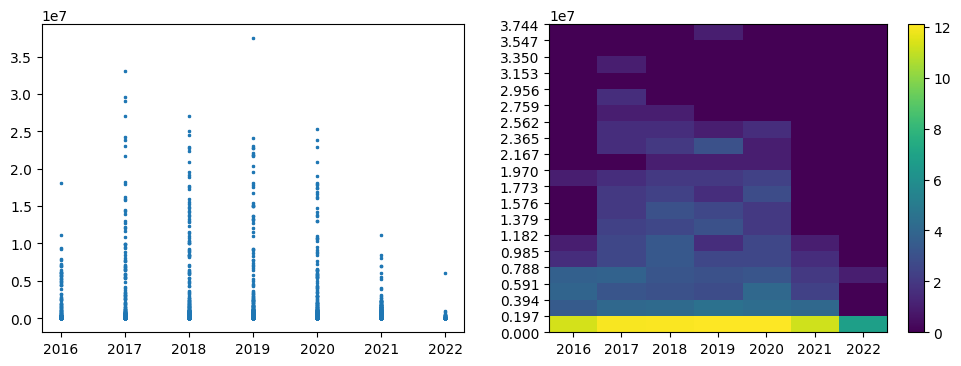

In [125]:

xs = df['Settlement_Year']
ys = df['Value']
# ys = np.log2(1+ys)
xbins = np.arange(min(xs),max(xs)+2,)-0.5
plot_scatter_2d(xs,ys,xbins=xbins);


In [ ]:
### 

1. put log function into the prediction of value. 
1. Use mixture components to represent claimed and failed cases. 
(so as we dont penalise the value prediction when the claim prediction is wrong).
  - like a zero-inflated model. ZINB.  
1. the prediction of year is better bounded, not to 2100
1. in terms of predicting the value, we can think about discretising the output.



1. Focus on the aggregated sum 2016-2021, instead of the individual values
1. REPO (glmm)
1. aggregate sum plot, and diagnostic plot 
  - if agg plot is great, then great
  - if agg plot sucks, then use diagnostic plot to argue.
  - pytorch? jax? (installed?)
  - write down tensorflow () functions to predict the agg sum.
    - problem is , if we only look at the agg sum, we have very limited data (6 data points)
    - that's why we have to inject structure into our model (10000 cases as data point)
    - the obvious structure focus on each case equally. 
    - but in fact, we might need to bias towards high-value cases. 

1. Structure Of Model:
  - InputData ->  (YearToSettle, ValueToSettle) Jointly?
    

In [52]:

nfeat = 50
nyear = 20
nsample = 1000





step_train_model(
# output_dict = dict(value=np.random.random((nsample,1)).astype('float32'),year_to_settle=np.random.random((nsample,1))),
output_dict = [np.random.random((nsample,1)).astype('float32'), np.random.random((nsample,1))],
input_feats = np.random.random((nsample,nfeat)).astype('float32'),
nfeat = nfeat,
nyear = nyear,
is_test_nan = False,
output_file = "temp.pkl",
force = False,
sample_size = nsample,
num_steps =100,
learning_rate = 0.01,
)

value_log_rate_     mean:[-0.78367853]   stddev:[0.5733209]
value_log_rate_     mean:[0.02435923]   stddev:[0.43376103]
value_log_rate_     mean:[0.9108262]   stddev:[0.50307375]
value_log_rate_     mean:[-0.02707481]   stddev:[0.30800146]
value_log_rate_     mean:[0.1117301]   stddev:[0.37249017]
value_log_rate_     mean:[0.27924633]   stddev:[0.42168576]
value_log_rate_coef.0.sigmoid  mean:[0.3135276]   stddev:[0.5733209]
value_log_rate_coef.1.sigmoid  mean:[0.5060895]   stddev:[0.43376103]
value_log_rate_coef.2.sigmoid  mean:[0.7131692]   stddev:[0.50307375]
value_log_rate_coef.3.sigmoid  mean:[0.4932317]   stddev:[0.30800146]
value_log_rate_coef.4.sigmoid  mean:[0.5279035]   stddev:[0.37249017]
value_log_rate_coef.5.sigmoid  mean:[0.5693614]   stddev:[0.42168576]


/repos/miniconda3/lib/python3.7/site-packages/tensorflow_probability/python/internal/vectorization_util.py:93: UserWarning: Saw Tensor seed Tensor("seed:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Python `int` seed.'.format(seed))


TypeError: can only concatenate list (not "int") to list

0        0
1        4
2        4
3        4
4        1
        ..
22331    4
22332    0
22333    0
22334    4
22335    4
Length: 22336, dtype: int8

In [14]:

fn = 'dataset.csv'
(x,y),_= tidy_data(fn,None)
for k in 'Region Scheme Incident_Year Notification_Year Injury Cause Specialty Location'.split():
    x[k] = pd.Categorical(x[k])
    pass
# pd.Categorical(x['Region'])
x.head()

# x['Region'].cat


,Region,Scheme,IsClinical,Incident_Year,Notification_Year,Grouped Claim,PortalClaim,Injury,Cause,Specialty,Location,Age at incident,IsPatientMale,Distance,Est_Settlement_Year,Est_Claim_Outcome,Est_Value,Settlement_Year,Claim_Outcome,Value
0,Type_1,Type_1,1,2011,2015,1,0,Type_55,Type_37,Type_34,Type_3,69.0,0,5.1,2021,1,4900,2021,1,3500
1,Type_5,Type_1,1,2017,2017,1,0,Type_7,Type_86,Type_1,Type_1,0.0,1,6.8,2021,1,348794,2020,0,0
2,Type_5,Type_1,1,2014,2016,0,0,Type_28,Type_8,Type_1,Type_1,22.0,0,10.0,2016,0,0,2016,0,0
3,Type_5,Type_1,1,2018,2020,0,0,Type_24,Type_49,Type_5,Type_1,58.0,0,7.4,2020,0,0,2020,1,7500
4,Type_2,Type_1,1,2013,2015,1,0,Type_3,Type_8,Type_1,Type_1,20.0,0,4.5,2016,0,0,2016,0,0


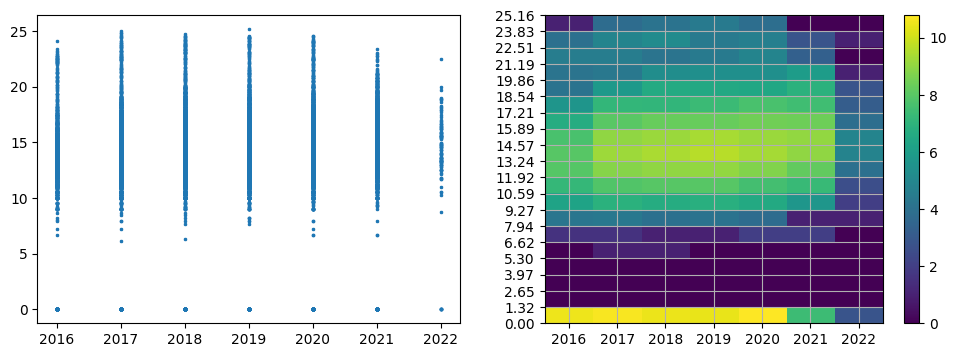

In [134]:

xs = df['Settlement_Year']
ys = df['Value']

ys = np.log2(1+ys)

xbins = np.arange(min(xs),max(xs)+2,)-0.5
plot_scatter_2d(xs,ys,xbins=xbins);

plt.grid(1)





/repos/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


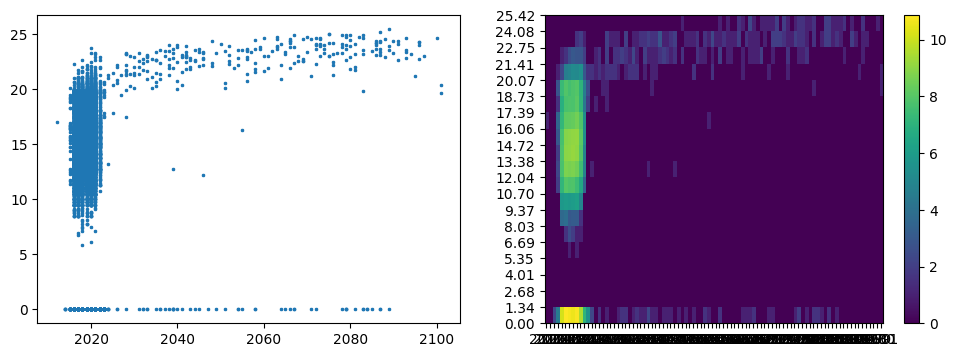

In [130]:
### 

xs = df['Est_Settlement_Year']
ys = df['Est_Value']
ys = np.log2(1+ys)


xbins = np.arange(min(xs),max(xs)+2,)-0.5
plot_scatter_2d(xs,ys,xbins=xbins);

/repos/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)




Prediction of Value is weirdly systematically biased 



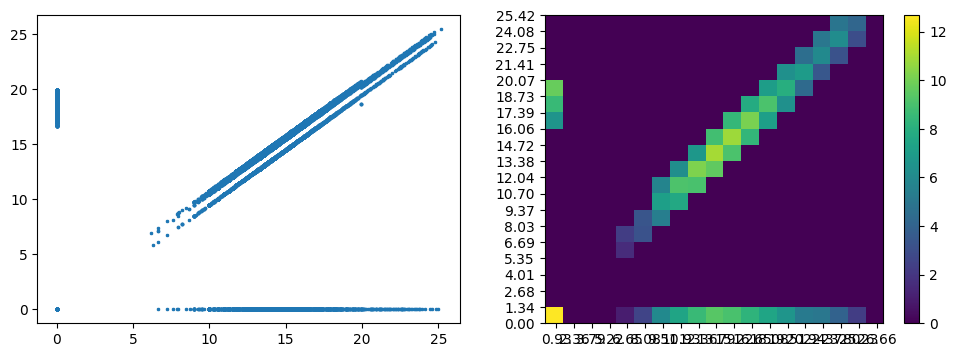

In [133]:
### 
xs = df['Value']
ys = df['Est_Value']
xs = np.log2(1+xs)
ys = np.log2(1+ys)

# xbins = np.arange(min(xs),max(xs)+2,)-0.5
xbins = None
FIG_VALUE_PRED = plot_scatter_2d(xs,ys,xbins=xbins);
plt.close()

import IPython.display as ipd

def rd(x):
    # xx = ipd.display_markdown(x)
    xx = ipd.display(ipd.Markdown(x))
    return xx
    # xx = ipd.display(xx)

text = '''

Prediction of Value is weirdly systematically biased 

'''

rd(text)
FIG_VALUE_PRED


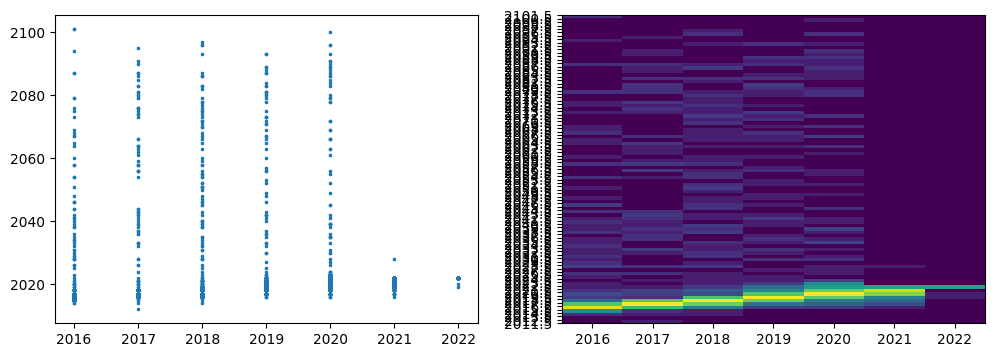

In [112]:
### 
xs = df['Settlement_Year']
ys = df['Est_Settlement_Year']
# ys = np.log2(1+ys)

xbins = np.arange(min(xs),max(xs)+2,)-0.5
ybins = np.arange(min(ys),max(ys)+2,)-0.5
# xbins = np.arange(min(xs),max(xs)+2,)-0.5
# xbins = None
plot_scatter_2d(xs,ys,xbins=xbins,ybins=ybins);


In [3]:
def plot_provision(df, maxim):
    df["Total"] = df["Outcome"] * df["Value"]
    Forecast = df.groupby(["YearsToSettle"])["Total"].agg("sum")
    plt.bar(Forecast.index, Forecast)
    plt.xlabel("Settlement year")
    plt.ylabel("Total value of expected successful claims")
    plt.title("Provision for next 5 years"
    )
    plt.ylim((0, maxim))

In [4]:
data = {
    "id": list(range(10)),
    "Outcome": [0, 1, 0, 0, 1, 1, 1, 1, 1, 0],
    "Value": [200, 340, 500, 120, 1000, 50, 100, 20000, 400, 100],
    "YearsToSettle": [1, 0, 1, 1, 2, 3, 4, 0, 2, 4],
}
dfP = pd.DataFrame(data)
dfP

,id,Outcome,Value,YearsToSettle
0,0,0,200,1
1,1,1,340,0
2,2,0,500,1
3,3,0,120,1
4,4,1,1000,2
5,5,1,50,3
6,6,1,100,4
7,7,1,20000,0
8,8,1,400,2
9,9,0,100,4


In [ ]:
#
'''
1. Do we care more about predicting all cases correctly,
or predicting important cases correctly ?   

Do we want to allocate more importance to high-value cases? 


'''

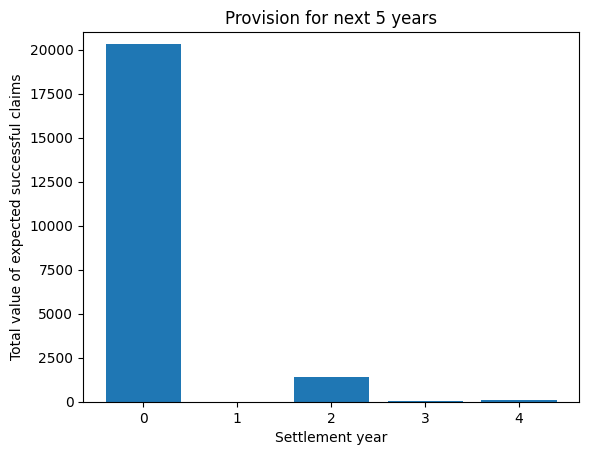

In [5]:
MAX = 21000
# Picture 1 - claim 7 successful and expected to have value of 20K and settled this year
plot_provision(dfP, MAX)

In [6]:
dfP

,id,Outcome,Value,YearsToSettle,Total
0,0,0,200,1,0
1,1,1,340,0,340
2,2,0,500,1,0
3,3,0,120,1,0
4,4,1,1000,2,1000
5,5,1,50,3,50
6,6,1,100,4,100
7,7,1,20000,0,20000
8,8,1,400,2,400
9,9,0,100,4,0


In [7]:
# Now estimated settlement year is 3 for claim 7 (high profile claim)
dfP.at[7, "YearsToSettle"] = 3

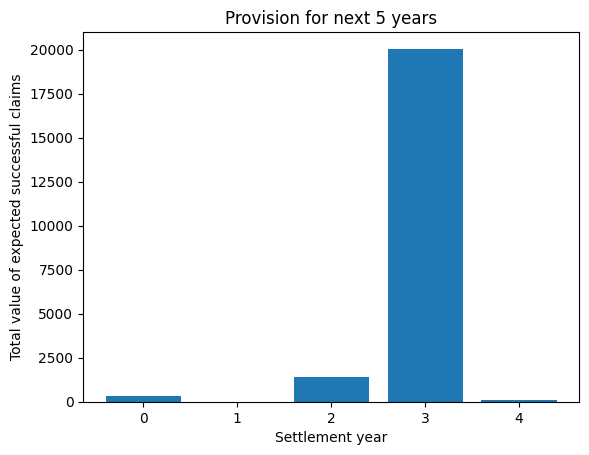

In [8]:
# How does it affect provisioning (big picture)?
plot_provision(dfP, MAX)

In [9]:
# Now reserves for claim 7 changed and it's not a high-profile claim anymore
dfP.at[7, "Value"] = 2000

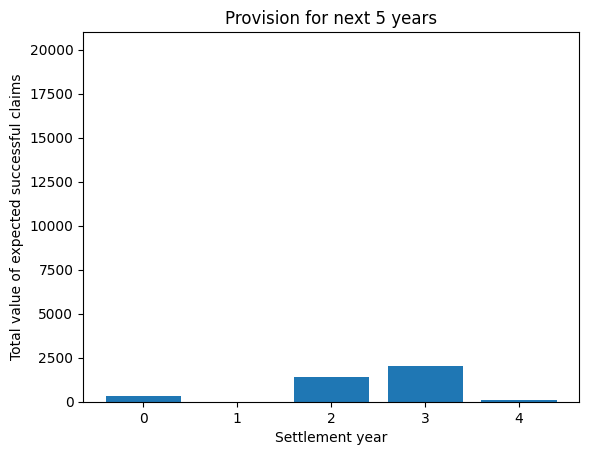

In [10]:
# How does it affect provisioning (big picture)?
plot_provision(dfP, MAX)